<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## Iterative Phase Estimation Algorithm


The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Antonio Córcoles, Jay Gambetta, Rudy Raymond

## Quantum Phase Estimation (QPE)

The Quantum Phase Estimation (QPE) algorithm solves the problem of finding unknown eigenvalues of a unitary operator. The attractiveness of the QPE algorithm lies in no small part in the fact that it is a key ingredient of some other very powerful algorithms like order finding and Shor's. 

In a standard textbook such as described in Nielsen & Chuang <i>Quantum Computation and Quantum Information</i>, in the QPE each bit of the phase is encoded in a different qubit on a register by using the phase kickback property of controlled-Unitary operations. This is followed by an inverse Quantum Fourier Transform operation which yields an n-bit approximation to the phase by reading the n-qubit register.

## Iterative Phase Estimation Algorithm (IPEA)
The QPE algorithm can however be realized in a much smaller qubit system by iterating the steps on a system of just two qubits. This is called the Iterative Phase Estimation Algorithm (IPEA).

Consider the problem of finding $\varphi$ given $|\Psi\rangle$ and $U$ in $U |\Psi\rangle = e^{i \phi} | \Psi \rangle$, with $\phi = 2 \pi \varphi$. Let's assume for now that $\varphi$ can be written as $\varphi = \varphi_1/2 + \varphi_2/4 + ... + \varphi_m/2^m = 0.\varphi_1 \varphi_2 ... \varphi_m$, where we have defined the notation $0.\varphi_1 \varphi_2 ... \varphi_m$. Now, if we have two qubits, $q_0$ and $q_1$, and we initialize them as $q_0 \rightarrow |+\rangle$ and $q_1 \rightarrow |\Psi \rangle$, then, after applying a control-U between $q_0$ and $q_1$ $2^t$ times the state of $q_0$ can be written as $|0\rangle + e^{i 2 \pi 2^{t} \varphi} | 1 \rangle$. That is, the phase of $U$ has been kicked back into $q_0$ as many times as the control operation has been performed.

For $t=0$, we have a total phase in $q_0$ of $e^{i 2 \pi 2^{0} \varphi} = e^{i 2 \pi \varphi} = e^{i 2 \pi 0.\varphi_1 \varphi_2 ... \varphi_m}$

For $t=1$, the phase would be $e^{i 2 \pi 2^{1} \varphi} = e^{i 2 \pi \varphi_1} e^{i 2 \pi 0.\varphi_2 \varphi_3 ... \varphi_m}$

For $t=2$, $e^{i 2 \pi 2^{2} \varphi} = e^{i 2 \pi 2 \varphi_1} e^{i 2 \pi \varphi_2} e^{i 2 \pi 0.\varphi_3 \varphi_4 ... \varphi_m}$

And for $t=m-1$, $e^{i 2 \pi 2^{m-1} \varphi} = e^{i 2 \pi 2^{m-2} \varphi_1} e^{i 2 \pi 2^{m-3} \varphi_2} ... e^{i 2 \pi 2^{-1} \varphi_m} = e^{i 2 \pi 0.\varphi_m}$. Now, note that if we perform a Hadamard operation on the state $|0\rangle + e^{i 2 \pi 0.\varphi_m}|1\rangle$ and perform a measurement in the standard basis, we obtain $|0\rangle$ if $\varphi_m = 0$ and $|1\rangle$ if $\varphi_m = 1$. 

So, in the first step of the IPEA we directly measure the least significant bit of the phase $\varphi$, $\varphi_m$, by initializing the 2-qubit register as described above, performing $2^{m-1}$ control-$U$ operations between the qubits, and measuring $q_0$ in the diagonal basis.

For the second step, we initialize the register in the same way and apply $2^{m-2}$ control-$U$ operations. The phase in $q_0$ after these operations is now $e^{i 2 \pi 0.\varphi_{m-1}\varphi_{m}}= e^{i 2 \pi 0.\varphi_{m-1}} e^{i 2 \pi \varphi_m/4}$. We see that prior to extracting the phase bit $\varphi_{m-1}$, we need to perform a phase correction of $\varphi_m /2$. This is equivalent to a rotation around the $Z-$axis of angle $-\varphi_m /4$.

Therefore, the $k$th step of the IPEA, giving $\varphi_{m-k+1}$, consists of the register initialization ($q_0$ in $|+\rangle$, $q_1$ in $|\Psi\rangle$), the application of control-$U$ $2^{m-k}$ times, a rotation around $Z$ of angle $\omega_k = -2 \pi 0.0\varphi_{k+1} ... \varphi_m$, a Hadamard transform to $q_0$ and a measurement of $q_0$ in the standard basis. Note that $q_1$ remains in the state $|\Psi\rangle$ throughout the algorithm.

## IPEA circuit

Let's first initialize the API and import the necessary packages

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

#from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram
# import basic plot tools
from qiskit.tools.visualization import plot_histogram

#from Qhelpers.misc import combineJobs
#from Qhelpers.misc import getData

import Qconfig
#api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken, Qconfig.config)
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

Now you can try the following circuit in the quantum simulator for a phase of $-5\pi/8 = 2 \pi \varphi$ and $m=4$. Note that the IPEA cannot be run in the real device in this form due to the current lack of feedback capability.

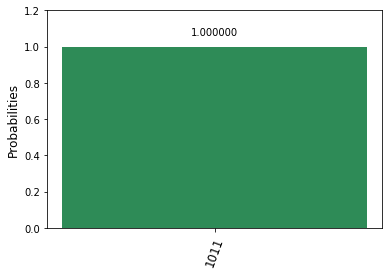

In [2]:
#we first define controlled gates used in the IPEA
from math import pi
def cu1fixed(qProg, c, t, a):
    qProg.u1(-a, t)
    qProg.cx(c, t)
    qProg.u1(a, t)
    qProg.cx(c, t)

def cu5pi8(qProg, c, t):
    cu1fixed(qProg, c, t, -5.0*pi/8.0)

#we then prepare quantum and classical registers and the circuit
qr = Q_program.create_quantum_register("qr", 2)
cr = Q_program.create_classical_register("cr", 4)
circuitName="IPEAonSimulator"
ipeaCircuit = Q_program.create_circuit(circuitName, [qr], [cr])

#apply IPEA
ipeaCircuit.h(qr[0])
for i in range(8):
    cu5pi8(ipeaCircuit, qr[0], qr[1])
ipeaCircuit.h(qr[0])
ipeaCircuit.measure(qr[0], cr[0])

ipeaCircuit.reset(qr[0])

ipeaCircuit.h(qr[0])
for i in range(4):
    cu5pi8(ipeaCircuit, qr[0], qr[1])
ipeaCircuit.u1(-pi/2, qr[0]).c_if(cr, 1)
ipeaCircuit.h(qr[0])
ipeaCircuit.measure(qr[0], cr[1])

ipeaCircuit.reset(qr[0])

ipeaCircuit.h(qr[0])
for i in range(2):
    cu5pi8(ipeaCircuit, qr[0], qr[1])
ipeaCircuit.u1(-pi/4, qr[0]).c_if(cr, 1)
ipeaCircuit.u1(-pi/2, qr[0]).c_if(cr, 2)
ipeaCircuit.u1(-3*pi/4, qr[0]).c_if(cr, 3)
ipeaCircuit.h(qr[0])
ipeaCircuit.measure(qr[0], cr[2])

ipeaCircuit.reset(qr[0])

ipeaCircuit.h(qr[0])
cu5pi8(ipeaCircuit, qr[0], qr[1])
ipeaCircuit.u1(-pi/8, qr[0]).c_if(cr, 1)
ipeaCircuit.u1(-2*pi/8, qr[0]).c_if(cr, 2)
ipeaCircuit.u1(-3*pi/8, qr[0]).c_if(cr, 3)
ipeaCircuit.u1(-4*pi/8, qr[0]).c_if(cr, 4)
ipeaCircuit.u1(-5*pi/8, qr[0]).c_if(cr, 5)
ipeaCircuit.u1(-6*pi/8, qr[0]).c_if(cr, 6)
ipeaCircuit.u1(-7*pi/8, qr[0]).c_if(cr, 7)
ipeaCircuit.h(qr[0])
ipeaCircuit.measure(qr[0], cr[3])

backend = "local_qasm_simulator"
shots = 1000
results = Q_program.execute([circuitName], backend=backend, shots=shots)
plot_histogram(results.get_counts(circuitName))
    

The results are given in terms of $\varphi = 0.\varphi_1 \varphi_2 \varphi_3 \varphi_4$, with the least significant digit ($\varphi_4$) as the leftmost bit in the classical register. The result is $\varphi = 11/16$, from which $\phi = 2\pi \varphi = 11 \pi/8 = 2 \pi - 5\pi/8$, as encoded in the circuit. 

## IPEA in the real device

As we have mentioned before, we currently lack the ability of using measurement feedback or feedforward, along with qubit resetting, on the real device in the Quantum Experience. However, we still can implement a segmentized version of the IPEA by extracting the information about the phase one bit at a time.

Try the following four circuits in the real device. They estimate the same phase as in the previous example (-5$\pi/8$), one bit at a time, from least ($\varphi_4$) to most ($\varphi_1$) significant bit.

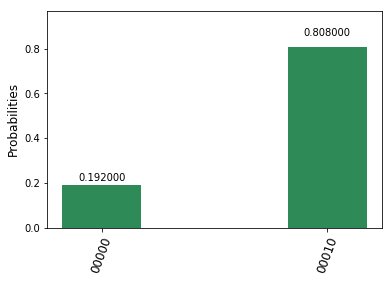

In [3]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url
circuitName = "IPEAonReal_Step1"
#we then prepare quantum and classical registers and the circuit
qr = Q_program.create_quantum_register("qr", 5)
cr = Q_program.create_classical_register("cr", 5)
realStep1Circuit = Q_program.create_circuit(circuitName, [qr], [cr])

#apply IPEA
realStep1Circuit.h(qr[0])
for i in range(8):
    cu5pi8(realStep1Circuit, qr[0], qr[1])
realStep1Circuit.h(qr[0])
realStep1Circuit.measure(qr[0], cr[0])

backend = "ibmqx4"
backend_config = Q_program.get_backend_configuration(backend) #we get the config of backend to get its coupling map
shots = 1000
results = Q_program.execute([circuitName], backend=backend, shots=shots, coupling_map=backend_config["coupling_map"])
plot_histogram(results.get_counts(circuitName))

In the first step of IPEA as above, we obtained the bit "1" with probability close to one. We then proceed to the second step of IPEA assuming that we have identified the result of the first step correctly, as below. 

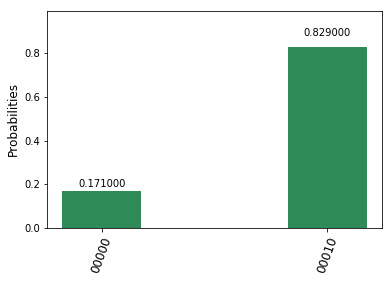

In [4]:
circuitName = "IPEAonReal_Step2"
realStep2Circuit = Q_program.create_circuit(circuitName, [qr], [cr])

#apply IPEA
realStep2Circuit.h(qr[0])
for i in range(4):
    cu5pi8(realStep2Circuit, qr[0], qr[1])
realStep2Circuit.u1(-pi/2, qr[0]) #assuming the value of the measurement on Step 1
realStep2Circuit.h(qr[0])
realStep2Circuit.measure(qr[0], cr[0])

results = Q_program.execute([circuitName], backend=backend, shots=shots, coupling_map=backend_config["coupling_map"])
plot_histogram(results.get_counts(circuitName))


In the second step of IPEA as above, we obtained the bit "1" with probability close to one. We then proceed to the third step of IPEA assuming that we have identified the result of the first and second steps correctly, as below.

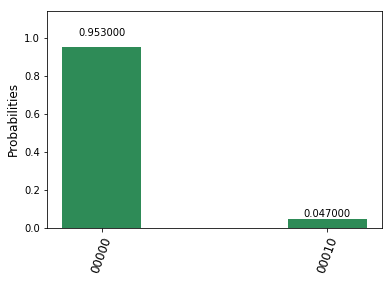

In [5]:
circuitName = "IPEAonReal_Step3"
realStep3Circuit = Q_program.create_circuit(circuitName, [qr], [cr])

#apply IPEA
realStep3Circuit.h(qr[0])
for i in range(2):
    cu5pi8(realStep3Circuit, qr[0], qr[1])
realStep3Circuit.u1(-3*pi/4, qr[0]) #assuming the value of the measurement on Step 1 and Step 2
realStep3Circuit.h(qr[0])
realStep3Circuit.measure(qr[0], cr[0])

results = Q_program.execute([circuitName], backend=backend, shots=shots, coupling_map=backend_config["coupling_map"])
plot_histogram(results.get_counts(circuitName))

In the third step of IPEA as above, we obtained the bit "0" with probability close to one. We then proceed to the fourth step of IPEA assuming that we have identified the result of the first, second, and third steps correctly, as below.

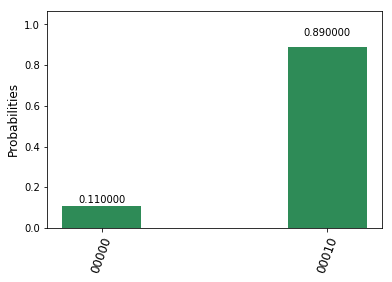

In [6]:
circuitName = "IPEAonReal_Step4"
realStep4Circuit = Q_program.create_circuit(circuitName, [qr], [cr])

#apply IPEA
realStep4Circuit.h(qr[0])
cu5pi8(realStep4Circuit, qr[0], qr[1])
realStep4Circuit.u1(-3*pi/8, qr[0]) #assuming the value of the measurement on Step 1, 2, and 3
realStep4Circuit.h(qr[0])
realStep4Circuit.measure(qr[0], cr[0])

results = Q_program.execute([circuitName], backend=backend, shots=shots, coupling_map=backend_config["coupling_map"])
plot_histogram(results.get_counts(circuitName))

In the fourt step of the IPEA, we identified the bit "1" with high probability. In summary, we can conclude with high probability that the binary string of the phase is "1011", that is eleven in the decimal.  

We have left aside the case when $\varphi$ does not accept a decomposition of the form $\varphi = \varphi_1/2 + \varphi_2/4 + ... + \varphi_m/2^m$. In that case, it can be shown that we can still use the IPEA to obtain $\varphi$ to an accuracy of $2^{-m}$ with greater than a constant probability independent of $m$ (around $81\%$ [1]).

[1] M. Dobsicek *et al. Phys. Rev. A* **76**, 030306 (2007)

In [1]:
%run "../version.ipynb"

Package,Version
QISKit,0.4.8
IBMQuantumExperience,>= 1.8.26
numpy,">= 1.13, < 1.14"
scipy,">= 0.19, < 0.20"
matplotlib,">= 2.0, < 2.1"
